### Motivation

This notebook performs training a classification model into `PA` and `AP` view. This model is necessary to estimate the quality of the generative adversarial network. The generated images in the `PA` projection obtained from the `AP` projection will be evaluated by this model. The model was trained at 99.44% accuracy on the test sample, so it is expected that perfectly generated images in `PA` projection will receive a prediction of `PA` with an accuracy of 99%.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/chest_x_ray

/content/drive/MyDrive/chest_x_ray


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
import torch
from torch import nn
from torchvision import models, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [5]:
from dataset import ClassificationDataset
from config import MAPPER, plot_progress

In [8]:
data = pd.read_csv('position.csv')

In [9]:
data['position'] = data['position'].map(MAPPER)

In [10]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['position'])

In [11]:
batch_size = 64
train_dataset = ClassificationDataset(data_train['name'].values, data_train['position'].values)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataset = ClassificationDataset(data_test['name'].values, data_test['position'].values)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

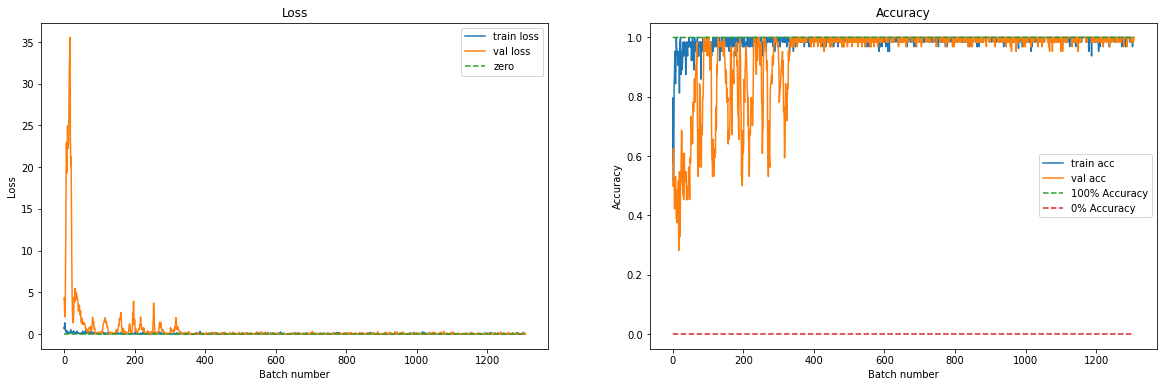

In [15]:
epochs = 4

train_accs = []
test_accs = []

train_losses = []
test_losses = []

for epoch in range(epochs):
    correct_train = 0
    correct_test = 0
    for train_batch in train_dataloader:
        model.train()
        data_train = train_batch['image'].to(device)
        target_train = train_batch['label'].to(device)

        optimizer.zero_grad()
        out_train = model(data_train.float())
        _, preds_train = torch.max(out_train, 1)
        train_loss = criterion(out_train, target_train)

        train_loss.backward()
        optimizer.step()
        
        test_batch = next(iter(test_dataloader))
        model.eval()
        with torch.no_grad():
            data_test = test_batch['image'].to(device)
            target_test = test_batch['label'].to(device)
            
            out_test = model(data_test.float())
            _, preds_test = torch.max(out_test, 1)
            test_loss = criterion(out_test, target_test)

        train_accs.append(accuracy_score(train_batch['label'].numpy(), preds_train.detach().cpu().numpy()))
        test_accs.append(accuracy_score(test_batch['label'].numpy(), preds_test.detach().cpu().numpy()))
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())  
        
        plot_progress(train_losses, train_accs, test_losses, test_accs)
    
    scheduler.step()

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f'weights/resnet18_views_epoch_{epoch + 1}.pt')

### Moving average accuracy per batch

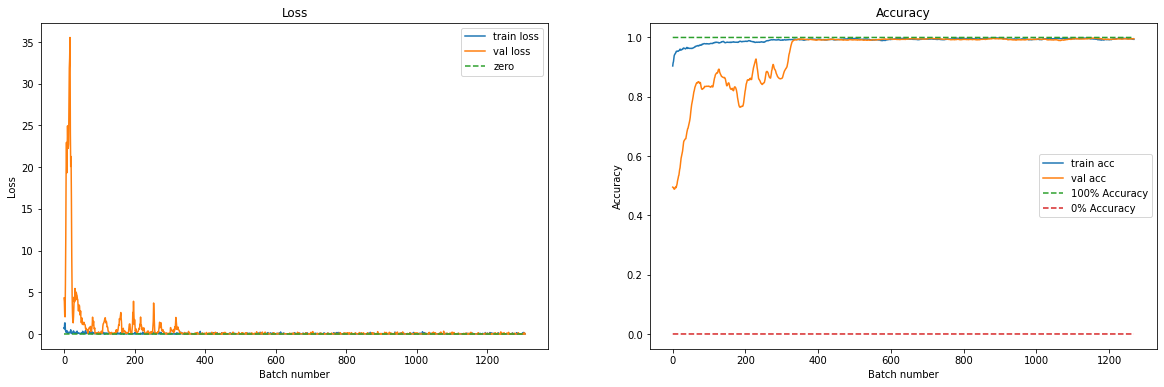

In [18]:
w = 40
train_acc_mov = np.convolve(np.array(train_accs), np.ones(w), 'valid') / w
test_acc_mov = np.convolve(np.array(test_accs), np.ones(w), 'valid') / w
plot_progress(train_losses, train_acc_mov, test_losses, test_acc_mov)

### Test accuracy

In [21]:
accuracy = 0

model.eval()
for test_batch in test_dataloader:
    with torch.no_grad():
        data_test = test_batch['image'].to(device)
        out_test = model(data_test.float())
        _, preds_test = torch.max(out_test, 1)

        accuracy += sum(test_batch['label'].numpy() == preds_test.detach().cpu().numpy())

print(f'Total test accuracy: {accuracy / len(test_dataset) * 100 :.2f}%')

Total test accuracy: 99.44%
